In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pingouin as pg
import plotly.express as px
import seaborn as sns 
from statannot import add_stat_annotation
import os
import copy
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [65]:
## savgol filter ##
def SG_fil(data,window,column_name,order=2):
    df = data.copy()
    for n in column_name:
        df[n] = savgol_filter(df.loc[:,n],window,order)
    return df

def lumin2cogload(lumin):
    # coeff_left = [2.451072052, -15.47037207, 2.49154129]
    # coeff_right = [2.489320955, -13.62467234, 2.540344354]
    coeff_left = [1.326173, -4.42176, 3.016348]
    coeff_right = [1.225595, -5.16006, 3.3087083]
    cogload_adjust_left = coeff_left[0]*np.exp(coeff_left[1]*lumin) + coeff_left[2]
    cogload_adjust_right = coeff_right[0]*np.exp(coeff_right[1]*lumin) + coeff_right[2]
    return cogload_adjust_left, cogload_adjust_right

def read_data(path):
    data_raw = []
    for home, dirs, files in os.walk(path):
        for filename in files:
            t = pd.read_csv(home+"/"+filename,index_col=0)
            t = t[40:-1].reset_index()

            t[["participant_id"]] = filename[1:3]
            t[["condition"]] = filename[4:6]

            t['LeftPupilD'][t['LeftPupilD']<0] = np.nan
            t['RightPupilD'][t['RightPupilD']<0] = np.nan
            t[['LeftPupilD','RightPupilD']] = t[['LeftPupilD','RightPupilD']].interpolate(method='linear',axis=0,limit_direction ='both')
            t = SG_fil(t,5,['LeftPupilD','RightPupilD','Lumin'])

            (t[['cogload_adjust_left']], t[['cogload_adjust_right']]) = lumin2cogload(t[['Lumin']])
            t[['cogload_left']] = t[['LeftPupilD']].values - t[['cogload_adjust_left']].values
            t[['cogload_right']] = t[['RightPupilD']].values - t[['cogload_adjust_right']].values
            data_raw.append(t)
            
    return data_raw

## Calculate the time of each mission ##
def total_data_analysis(data_raw):
    data_analysis = pd.DataFrame()
    for i in range(len(data_raw)):      
        mission_time = np.zeros(2)
        time_all = len(data_raw[i])/90
        condition = data_raw[i][["condition"]][0:1].values.ravel()[0]
        participant_id = data_raw[i][["participant_id"]][0:1].values.ravel()[0]
        mission_group = data_raw[i].groupby('CollisionTargetName')
        mission_white = mission_group.get_group('Object_White')
        mission_purple = mission_group.get_group('Object_Purple')
        
        time_white = len(mission_white)/90
        time_purple = len(mission_purple)/90
        # cogload_left = (data_raw[i]["cogload_left"].mean())
        # cogload_right = (data_raw[i]["cogload_right"].mean())
        cogload_left = (data_raw[i]["LeftPupilD"].mean())
        cogload_right = (data_raw[i]["RightPupilD"].mean())
        average_cogload = (cogload_left + cogload_right)/2

        data_analysis = data_analysis.append(pd.DataFrame([[condition,participant_id,time_all,time_white,time_purple,average_cogload,
                                                            cogload_left,cogload_right,
                                                            ]],
                                                columns=["condition","participant_id","time_all","time_white","time_purple","average_cogload",
                                                        "cogload_left","cogload_right",
                                                        ]),
                                                ignore_index=True)
    
    return data_analysis

In [50]:
path = '../../data/2022_11_09/test/'
data_raw = read_data(path)

<ipython-input-47-cb694f76e52a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['LeftPupilD'][t['LeftPupilD']<0] = np.nan
<ipython-input-47-cb694f76e52a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['RightPupilD'][t['RightPupilD']<0] = np.nan
<ipython-input-47-cb694f76e52a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['LeftPupilD'][t['LeftPupilD']<0] = np.nan
<ipython-input-47-cb694f76e52a>:28: SettingWithCopyWarning:

In [66]:
data_analysis = total_data_analysis(data_raw)

In [67]:
data_analysis

,condition,participant_id,time_all,time_white,time_purple,average_cogload,cogload_left,cogload_right
0,01,01,52.666667,11.344444,6.866667,3.115973,3.168608,3.063339
1,02,01,154.566667,34.000000,11.966667,3.190127,3.279304,3.100950
2,03,01,160.311111,25.066667,0.044444,3.154991,3.209582,3.100399
3,04,01,365.077778,28.477778,42.000000,3.256392,3.324063,3.188721
4,05,01,314.455556,99.288889,64.577778,3.175793,3.213764,3.137822
5,06,01,119.966667,8.511111,33.388889,3.188920,3.287383,3.090457
6,07,01,197.955556,34.300000,37.611111,3.181994,3.247136,3.116852
7,08,01,225.711111,92.188889,26.144444,3.205563,3.232366,3.178761
8,09,01,644.222222,8.244444,93.466667,3.297887,3.361241,3.234532
9,01,02,127.000000,0.111111,40.477778,3.917995,3.637470,4.198520


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
02 v.s. 06: Wilcoxon test (paired samples), P_val=8.125e-01 stat=6.000e+00
Using zero_method  pratt
03 v.s. 07: Wilcoxon test (paired samples), P_val=1.250e-01 stat=1.000e+00
Using zero_method  pratt
04 v.s. 08: Wilcoxon test (paired samples), P_val=1.250e-01 stat=1.000e+00
Using zero_method  pratt
05 v.s. 09: Wilcoxon test (paired samples), P_val=1.250e-01 stat=1.000e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
02 v.s. 06: Wilcoxon test (paired samples), P_val=6.250e-01 stat=5.000e+00
Using zero_method  pratt
03 v.s. 07: Wilcoxon test (paired samples), P_val=6.250e-01 stat=5.000e+00
Using zero_method  pratt
04 v.s. 08: Wilcoxon test (paired samples), P_v

Text(1715.6521739130435, 0.5, 'Average Cognitive Load')

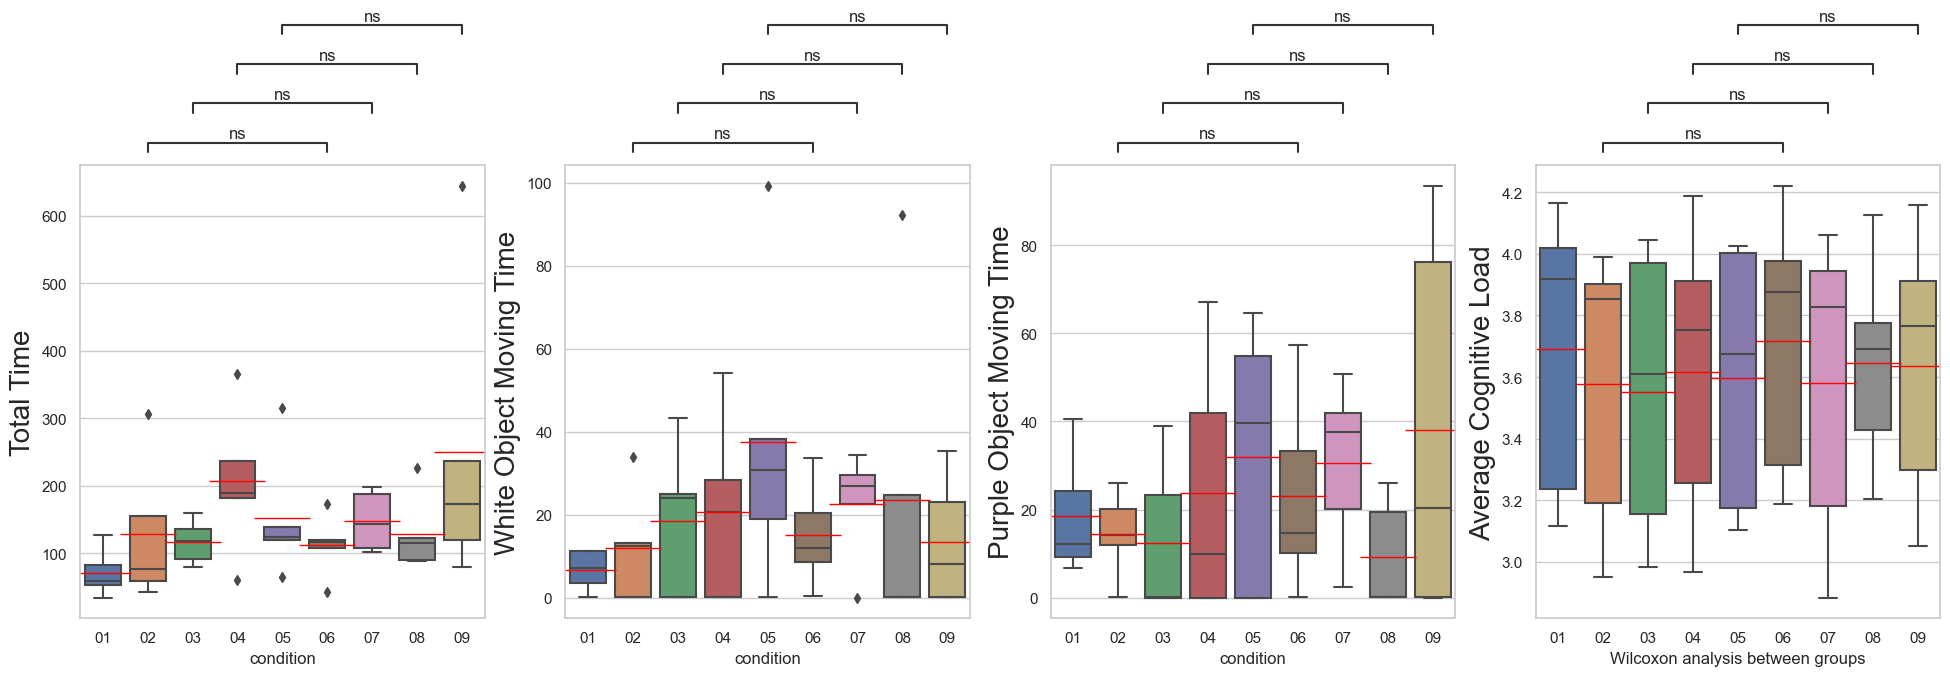

In [94]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'condition'
y_list = ["time_all","time_white","time_purple","average_cogload"]  
order = ["01","02","03","04","05","06","07","08","09"]
method = 'Wilcoxon'
# method = 'Kruskal'
data = data_analysis
# box_pairs=[
#          (order[0], order[1]),
#          (order[0], order[2]),
#          (order[0], order[3]),
#          (order[1], order[2]),
#          (order[1], order[3]),
#          (order[2], order[3]),
#             ]
box_pairs=[
         (order[1], order[5]),
         (order[2], order[6]),
         (order[3], order[7]),
         (order[4], order[8]),
            ]
average_line_length = "40"


fig, axes = plt.subplots(1,4, figsize=(24,6), dpi=100)
y = y_list[0]
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
# axes[0] = sns.violinplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[0].set_ylabel('Total Time', fontsize = 20)


y = y_list[1]
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[1].set_ylabel('White Object Moving Time', fontsize = 20)

y = y_list[2]
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[2].set_ylabel('Purple Object Moving Time', fontsize = 20)


y = y_list[3]
axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[3].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[3].set_ylabel('Average Cognitive Load', fontsize = 20)




In [ ]:
### ----------------------------------------------- Questionnaire ---------------------------------------------------------------------------

In [89]:
nasa_tlx = pd.read_csv("../../data/2022_11_09/questionnaire/NASA TLX - Delay Control.csv")

In [90]:
nasa_tlx[["Mental Demand",
         "Physical Demand",
         "Temporal Demand",
         "Performance ",
         "Effort ",
         "Frustration ",
         ]] = nasa_tlx[["Mental Demand",
         "Physical Demand",
         "Temporal Demand",
         "Performance ",
         "Effort ",
         "Frustration ",
         ]].astype(float)

In [91]:
nasa_tlx['total']= nasa_tlx.iloc[:,3]+nasa_tlx.iloc[:,4]+nasa_tlx.iloc[:,5]+nasa_tlx.iloc[:,6]\
                    +nasa_tlx.iloc[:,7]+nasa_tlx.iloc[:,8]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
2 v.s. 6: Wilcoxon test (paired samples), P_val=6.250e-01 stat=5.000e+00
Using zero_method  pratt
3 v.s. 7: Wilcoxon test (paired samples), P_val=3.125e-01 stat=2.500e+00
Using zero_method  pratt
4 v.s. 8: Wilcoxon test (paired samples), P_val=8.125e-01 stat=6.000e+00
Using zero_method  pratt
5 v.s. 9: Wilcoxon test (paired samples), P_val=4.375e-01 stat=4.000e+00


IndexError: list index out of range

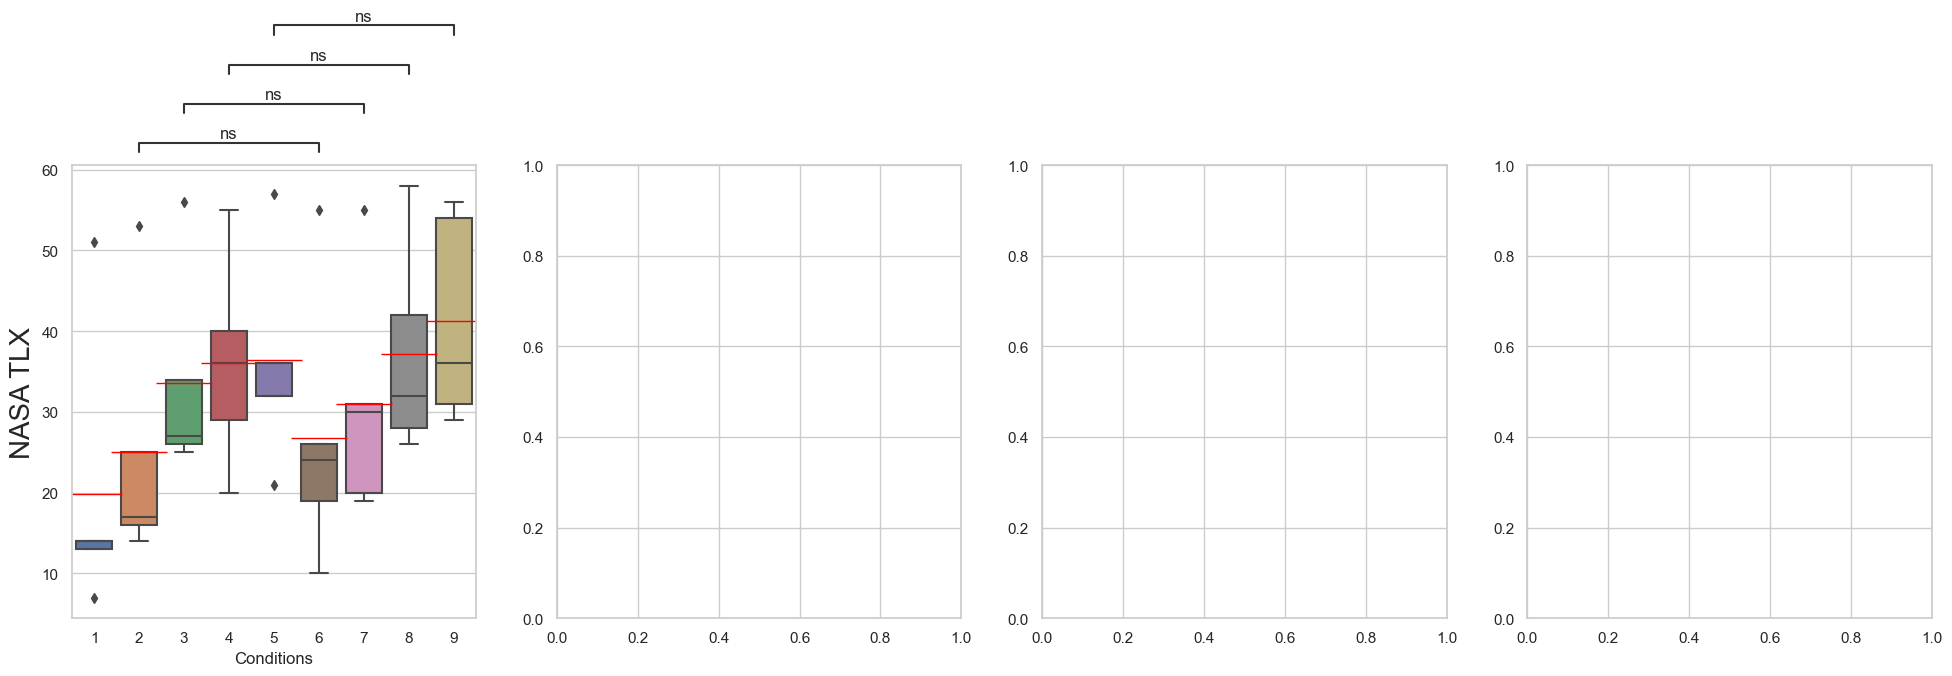

In [93]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'Conditions'
y_list = ["total"]  
# order = ["1","2","3","4","5","6","7","8","9"]
order = [1,2,3,4,5,6,7,8,9]
method = 'Wilcoxon'
# method = 'Kruskal'
data = nasa_tlx
# box_pairs=[
#          (order[0], order[1]),
#          (order[0], order[2]),
#          (order[0], order[3]),
#          (order[1], order[2]),
#          (order[1], order[3]),
#          (order[2], order[3]),
#             ]
box_pairs=[
         (order[1], order[5]),
         (order[2], order[6]),
         (order[3], order[7]),
         (order[4], order[8]),
            ]
average_line_length = "40"


fig, axes = plt.subplots(1,4, figsize=(24,6), dpi=100)
y = y_list[0]
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
# axes[0] = sns.violinplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[0].set_ylabel('NASA TLX', fontsize = 20)

y = y_list[1]
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)

y = y_list[2]
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)

y = y_list[3]
axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[3].set(xlabel = method + ' analysis between groups', ylabel=y)

In [ ]:
### -------------------------------------- Estimation Delay ---------------------------------------------

In [126]:
estimation_dalay_pd = pd.DataFrame()
estimation_dalay_pd['condition'] = [1,2,3,4,5,6,7,8,9]
estimation_dalay_pd['actual_visual_delay'] = [0,1.25,2.5,3.75,5,1.25,2.5,3.75,5]
estimation_dalay_pd['actual_haptic_delay'] = [0,0,0,0,0,0.25,0.25,0.25,0.25]
estimation_dalay_pd['p1_visual_delay'] = [0,0.5,3,3,4,1,3,2,5]
estimation_dalay_pd['p1_haptic_delay'] = [0,1.5,4,5,4,1.5,3,3,5]
estimation_dalay_pd['p2_visual_delay'] = [0.25,3,3,3,4.5,3,2.5,3,5]
estimation_dalay_pd['p2_haptic_delay'] = [0.25,1,2,4,4,2,2.5,1.5,5]
estimation_dalay_pd['p3_visual_delay'] = [1.0,2,3,4,5,3,3,5,4]
estimation_dalay_pd['p3_haptic_delay'] = [1.0,1,1,1,1,2,1,5,1]
estimation_dalay_pd['p4_visual_delay'] = [0.0,1,4,4,5,1,3,4,5]
estimation_dalay_pd['p4_haptic_delay'] = [0.0,1,1,2,1,0,0,1,1]
estimation_dalay_pd['p5_visual_delay'] = [0.5,1.5,4,5,5,2,4,3,5]
estimation_dalay_pd['p5_haptic_delay'] = [0.5,0.5,0.5,2,0.5,1,0.5,0,1.5]

In [131]:
for i in range(1,6):
    estimation_dalay_pd['p%s_visual_delay_difference' %i] = estimation_dalay_pd['p%s_visual_delay' %i] - estimation_dalay_pd['actual_visual_delay']
    estimation_dalay_pd['p%s_haptic_delay_difference' %i] = estimation_dalay_pd['p%s_haptic_delay' %i] - estimation_dalay_pd['actual_haptic_delay']

In [132]:
estimation_dalay_pd['visual_delay_difference_total'] = [0.0,0,0,0,0,0,0,0,0]
estimation_dalay_pd['haptic_delay_difference_total'] = [0.0,0,0,0,0,0,0,0,0]
for i in [13,15,17,19,21]:
    estimation_dalay_pd['visual_delay_difference_total'] = estimation_dalay_pd['visual_delay_difference_total'] + estimation_dalay_pd.iloc[:,i]
for i in [14,16,18,20,22]:
    estimation_dalay_pd['haptic_delay_difference_total'] = estimation_dalay_pd['haptic_delay_difference_total'] + estimation_dalay_pd.iloc[:,i]

In [136]:
estimation_dalay_pd = pd.read_excel('../../data/2022_11_09/estimation_dalay_pd.xlsx')

In [137]:
estimation_dalay_pd

,participant,condition,visual_delay,haptic_delay,visual_delay_difference,haptic_delay_difference
0,0,1,0.00,0.00,0.00,0.00
1,0,2,1.25,0.00,0.00,0.00
2,0,3,2.50,0.00,0.00,0.00
3,0,4,3.75,0.00,0.00,0.00
4,0,5,5.00,0.00,0.00,0.00
5,0,6,1.25,0.25,0.00,0.00
6,0,7,2.50,0.25,0.00,0.00
7,0,8,3.75,0.25,0.00,0.00
8,0,9,5.00,0.25,0.00,0.00
9,1,1,0.00,0.00,0.00,0.00


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
2 v.s. 6: Wilcoxon test (paired samples), P_val=8.635e-02 stat=0.000e+00
Using zero_method  pratt
3 v.s. 7: Wilcoxon test (paired samples), P_val=1.590e-01 stat=0.000e+00


c:\A\software\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\A\software\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Using zero_method  pratt
4 v.s. 8: Wilcoxon test (paired samples), P_val=4.927e-01 stat=4.500e+00
Using zero_method  pratt
5 v.s. 9: Wilcoxon test (paired samples), P_val=6.474e-01 stat=5.500e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
2 v.s. 6: Wilcoxon test (paired samples), P_val=7.505e-01 stat=8.500e+00
Using zero_method  pratt
3 v.s. 7: Wilcoxon test (paired samples), P_val=1.345e-01 stat=3.000e+00


c:\A\software\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\A\software\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Using zero_method  pratt
4 v.s. 8: Wilcoxon test (paired samples), P_val=3.978e-01 stat=6.000e+00
Using zero_method  pratt
5 v.s. 9: Wilcoxon test (paired samples), P_val=2.850e-01 stat=5.000e+00


IndexError: list index out of range

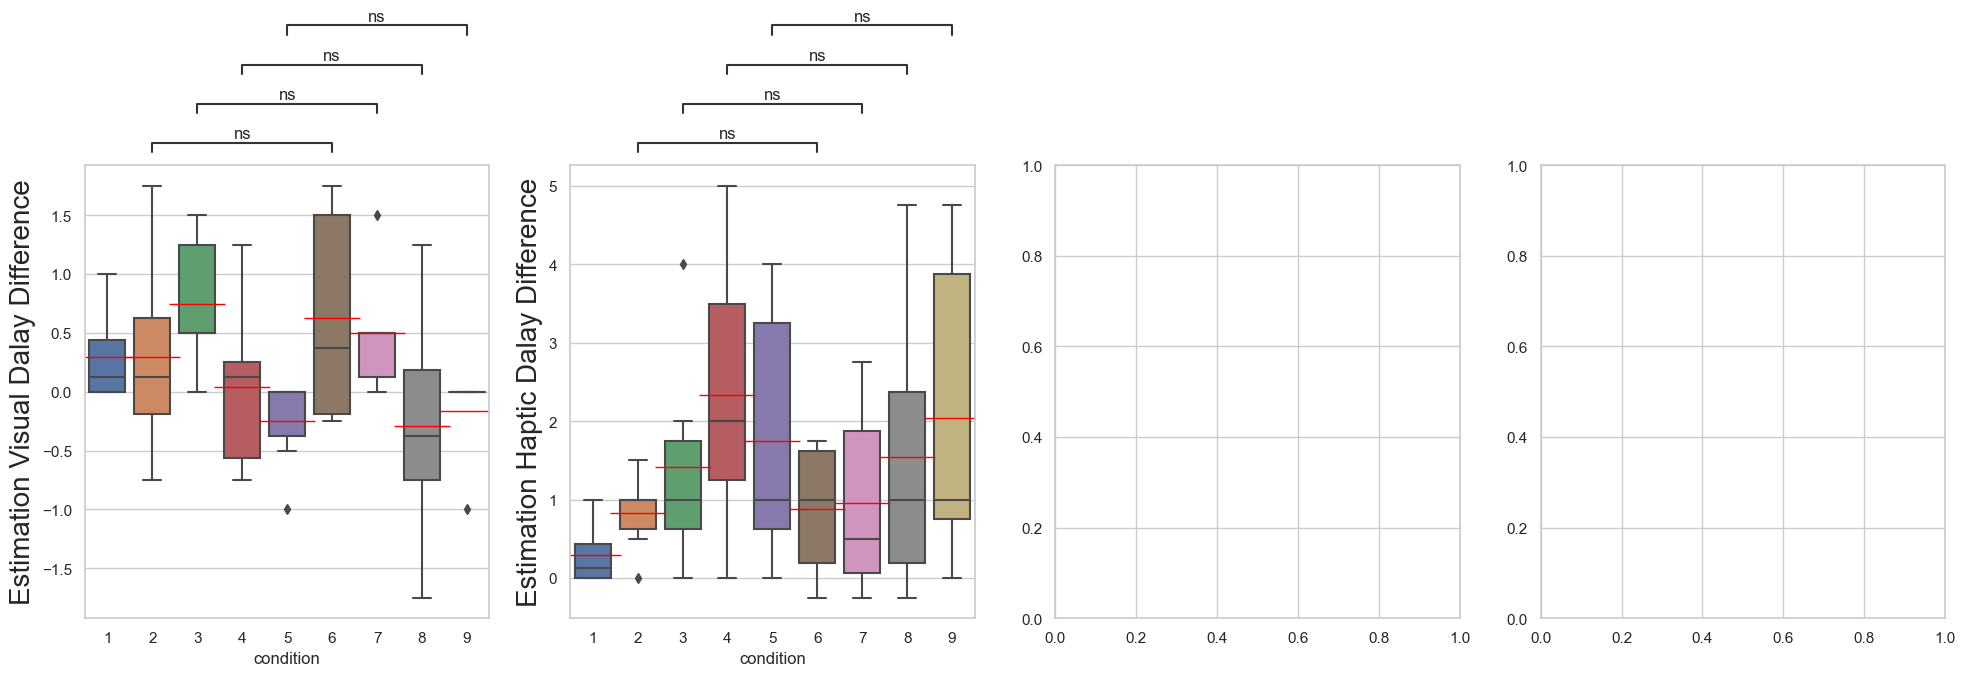

In [138]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'condition'
y_list = ["visual_delay_difference","haptic_delay_difference"]  
order = [1,2,3,4,5,6,7,8,9]
method = 'Wilcoxon'
# method = 'Kruskal'
data = estimation_dalay_pd
# box_pairs=[
#          (order[0], order[1]),
#          (order[0], order[2]),
#          (order[0], order[3]),
#          (order[1], order[2]),
#          (order[1], order[3]),
#          (order[2], order[3]),
#             ]
# box_pairs=[
#          (order[1], order[5]),
#          (order[2], order[6]),
#          (order[3], order[7]),
#          (order[4], order[8]),
#             ]
box_pairs=[
         (order[1], order[5]),
         (order[2], order[6]),
         (order[3], order[7]),
         (order[4], order[8]),
            ]
average_line_length = "40"


fig, axes = plt.subplots(1,4, figsize=(24,6), dpi=100)
y = y_list[0]
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
# axes[0] = sns.violinplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[0].set_ylabel('Estimation Visual Dalay Difference', fontsize = 20)

y = y_list[1]
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
# axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)
axes[1].set_ylabel('Estimation Haptic Dalay Difference', fontsize = 20)


y = y_list[2]
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)

y = y_list[3]
axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[3].set(xlabel = method + ' analysis between groups', ylabel=y)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto_low_cogload_auto v.s. auto_low_cogload_self: Kruskal-Wallis paired samples, P_val=1.988e-01 stat=1.651e+00
self_low_cogload_auto v.s. self_low_cogload_self: Kruskal-Wallis paired samples, P_val=1.746e-01 stat=1.843e+00
self_low_cogload_auto v.s. auto_low_cogload_auto: Kruskal-Wallis paired samples, P_val=5.206e-01 stat=4.126e-01
self_low_cogload_self v.s. auto_low_cogload_self: Kruskal-Wallis paired samples, P_val=9.858e-02 stat=2.728e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto_low_cogload_auto v.s. auto_low_cogload_self: Kruskal-Wallis paired samples, P_val=8.210e-02 stat=3.023e+00
self_low_cogload_auto v.s. self_low_cogload_self: Kruskal-Wallis paired samples, P_val=1.939e-01 stat=1.688e+00


IndexError: list index out of range

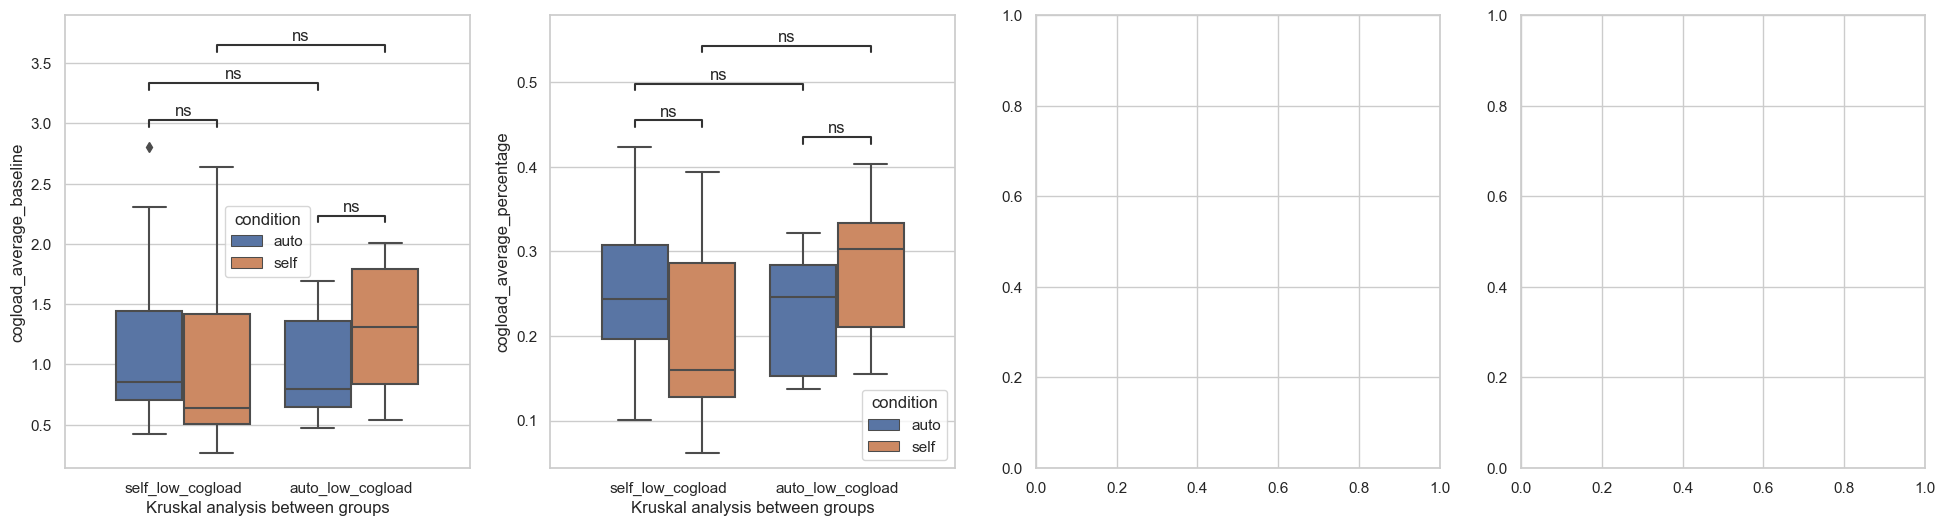

In [16]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'which_better'
y_list = ["task_finished_per_minute","damege_find_per_minute","score_per_minute","cogload_average_baseline"]  
# y_list = ["cogload_left_baseline","cogload_left_percentage","cogload_right_baseline","cogload_right_percentage"]  
# y_list = ["cogload_average_baseline","cogload_average_percentage"]
# order = ["cont","auto","self"]
order = ["auto_low_cogload","self_low_cogload"]
hue = "condition"
hue_order = ["auto","self"]

box_pairs = [
            ((order[0], hue_order[0]),(order[0], hue_order[1])),
            ((order[1], hue_order[0]),(order[1], hue_order[1])),
            ((order[0], hue_order[0]),(order[1], hue_order[0])),
            ((order[0], hue_order[1]),(order[1], hue_order[1])),
            ]

# method = 'Wilcoxon'
method = 'Kruskal'
data = data_two_pairwise
plot_line = 0

fig, axes = plt.subplots(1,4, figsize=(24,6), dpi=100)

y = y_list[0]
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, hue=hue)
# axes[0] = sns.violinplot(ax = axes[0], data=data, x=x, y=y, order=order)
if plot_line:
   for i in range(0,len(data),2):
      plot_data = np.zeros(2)
      for j in range(2):
         if data[[x]].values.ravel()[i+j] == order[0]:
            plot_data[0] = data[[y]].values.ravel()[i+j]
         if data[[x]].values.ravel()[i+j] == order[1]:
            plot_data[1] = data[[y]].values.ravel()[i+j]
      axes[0].plot(plot_data)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, hue=hue,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='inside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

y = y_list[1]
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,hue=hue,)
if plot_line:
   for i in range(0,len(data),2):
      plot_data = np.zeros(2)
      for j in range(2):
         if data[[x]].values.ravel()[i+j] == order[0]:
            plot_data[0] = data[[y]].values.ravel()[i+j]
         if data[[x]].values.ravel()[i+j] == order[1]:
            plot_data[1] = data[[y]].values.ravel()[i+j]
      axes[1].plot(plot_data)
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,hue=hue,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='inside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)

y = y_list[2]
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,hue=hue,)
if plot_line:
   for i in range(0,len(data),2):
      plot_data = np.zeros(2)
      for j in range(2):
         if data[[x]].values.ravel()[i+j] == order[0]:
            plot_data[0] = data[[y]].values.ravel()[i+j]
         if data[[x]].values.ravel()[i+j] == order[1]:
            plot_data[1] = data[[y]].values.ravel()[i+j]
      axes[2].plot(plot_data)
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,hue=hue,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='inside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)

y = y_list[3]
axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,hue=hue,)
if plot_line:
   for i in range(0,len(data),2):
      plot_data = np.zeros(2)
      for j in range(2):
         if data[[x]].values.ravel()[i+j] == order[0]:
            plot_data[0] = data[[y]].values.ravel()[i+j]
         if data[[x]].values.ravel()[i+j] == order[1]:
            plot_data[1] = data[[y]].values.ravel()[i+j]
      axes[3].plot(plot_data)
test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,hue=hue,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='inside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[3].set(xlabel = method + ' analysis between groups', ylabel=y)

In [20]:
### sample from raw data 
rate = 20
data_image = copy.deepcopy(data_auto[1])
subset = data_image[::rate]
## 3D Stastic ###
if 1:
    df = subset
    fig = px.scatter_3d(df, x='CameraPosX', y='CameraPosY', z='CameraPosZ',
                color='Trend_Sum',color_continuous_scale=px.colors.sequential.Viridis,symbol='light_state',symbol_sequence=["cross","circle"],opacity=0.8,)
    fig.update_traces(marker_size = 3)
    fig.show()

In [ ]:
######################## Trajectory and entropy #################################

In [5]:
def SampEn(U, m, r):
    """
    用于量化时间序列的可预测性
    :param U: 时间序列
    :param m: 模板向量维数
    :param r: 距离容忍度，一般取0.1~0.25倍的时间序列标准差，也可以理解为相似度的度量阈值
    :return: 返回一个-np.log(A/B)，该值越小预测难度越小
    """
    def _maxdist(x_i, x_j):
        """
         Chebyshev distance
        :param x_i:
        :param x_j:
        :return:
        """
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        
        return sum(C)

    N = len(U)
    if _phi(m) == 0:
        return 0.2
    else:
        return -np.log(_phi(m + 1) / _phi(m))
